#Grad_CAM: Gradient Weighted Class Activation Mapping

The rise of convolutional Neural Network has proven to be a breakthrough in machine learning, enabling deep neural networks to provide excellent performance in various vision related tasks varying from image classification to visual question answering. But with this benefit comes a drawback that as the deep NNs have become intricate, they have also become more harder to interpret.


---



Explainable AI is an approach that allows developers and users to understand the behaviour of different neural networks. One of the techniques of explainable AI is Grad_CAM (Gradient Weighted Class Activation Mapping).

Grad_cam is a rough localized map that highlights the areas of an image that are important for the model in predicting a certain target class. It uses the gradients of any target class flowing into the final convolutional layer to produce a localization map.

Following are the steps for generating a Grad_CAM:
  1. Derivative of the raw score of the target class with respect to the last convolution output
  2. Global Average Pooling of the derivative
  3. Linear combination with the last convolution output
  4. Normalizing the result
  5. Superimposing the heatmap and the original image

(details of each step will be provided when implemented)

In this notebook, we will first make a model via transfer learning having ResNet50V2 as the base model, however any pre-trained CNN model can be used, that will serve as the foundation of the grad_cam model. The grad_cam model will be used to get the last convolutional output as well as the softmax predictions.

# Importing dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Rescaling
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from os import listdir, path
from skimage.util import random_noise
from skimage import img_as_float
import math
import cv2
import os
import PIL
import shutil
import matplotlib.cm as cm
from IPython.display import Image

def display_expected_result(id, height):
  url_img = "https://drive.google.com/uc?id=" + id
  return Image(url=url_img, height=height)

# Loading Tensorflow dataset

In [2]:
import tensorflow_datasets as tfds

#loading cats_vs_dogs dataset from tensorflow
#cats_vs_dogs dataset only has train split, thats why we get a few images from the same split as test images
dataset_train = tfds.load("cats_vs_dogs", split = 'train[:5000]', as_supervised=True)
dataset_test = tfds.load("cats_vs_dogs", split = 'train[5000:6000]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteQWR6VU/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
print(len(dataset_train))
print(len(dataset_test))

5000
1000


In [4]:
#getting img matrixs and labels of each image
imgs_train_ds = dataset_train.map(lambda images, labels: images)
labels_train_ds = dataset_train.map(lambda images, labels: labels)

imgs_test_ds = dataset_test.map(lambda images, labels: images)
labels_test_ds = dataset_test.map(lambda images, labels: labels)

In [5]:
#for train images
#getting those images which have minimum 224 by 224 dimensions
#saving the indices of such images to get their corresponding labels
imgs_train_big = []
indexes = []

for i, img in enumerate(imgs_train_ds):
  if(img.shape[0] >= 224 and img.shape[1] >= 224):
    imgs_train_big.append(np.array(img))
    indexes.append(i)

labels_train_big = []
for i in labels_train_ds:
  labels_train_big.append(i)

labels_train_big = np.array(labels_train_big)
labels_train_big = labels_train_big[indexes]

In [6]:
#for test images
#getting those images which have minimum 224 by 224 dimensions
#saving the indices of such images to get their corresponding labels

imgs_test_big = []
indexes = []

for i, img in enumerate(imgs_test_ds):
  if(img.shape[0] >= 224 and img.shape[1] >= 224):
    imgs_test_big.append(np.array(img))
    indexes.append(i)

labels_test_big = []
for i in labels_test_ds:
  labels_test_big.append(i)

labels_test_big = np.array(labels_test_big)
labels_test_big = labels_test_big[indexes]

In [7]:
#for train
#resizing all the images to 224 by 224 dimension
for i in range(len(imgs_train_big)):
  imgs_train_big[i] = np.array(tf.image.resize(imgs_train_big[i], [224,224])).astype('uint8')
imgs_train_big = np.array(imgs_train_big)
print(imgs_train_big.shape)

(4462, 224, 224, 3)


In [8]:
#for test
#resizing all the images to 224 by 224 dimension
for i in range(len(imgs_test_big)):
  imgs_test_big[i] = np.array(tf.image.resize(imgs_test_big[i], [224,224])).astype('uint8')
imgs_test_big = np.array(imgs_test_big)
print(imgs_test_big.shape)

(879, 224, 224, 3)


In [9]:
print(len(imgs_train_big))
print(len(labels_train_big))
print(len(imgs_test_big))
print(len(labels_test_big))

4462
4462
879
879


In [10]:
#for train
#creating labels for cats and dogs images
cat_indexes = [] #will store the indices of cat images
dog_indexes = [] #will store the indices of dog images
cats_l =[] #will store the lables of cat images
dogs_l =[] #will store the lables of dog images

for i in range(len(labels_train_big)):
  if labels_train_big[i] == 0:
    cat_indexes.append(i)
    cats_l.append(1)
  else:
    dog_indexes.append(i)
    dogs_l.append(0)

print(len(cat_indexes))
print(len(dog_indexes))

#getting the cat images and dog images
cats = np.array(imgs_train_big)[cat_indexes]
dogs = np.array(imgs_train_big)[dog_indexes]

#combining the cats and dogs images and labels to get single arrays of train images and train labels
imgs_train_big = list(cats[:500]) + list(dogs[:500])
labels_train_big = cats_l[:500] + dogs_l[:500]

2233
2229


In [11]:
print(len(imgs_train_big))
print(len(labels_train_big))

1000
1000


In [12]:
#for tet
#creating labels for cats and dogs images
cat_indexes = [] #will store the indices of cat images
dog_indexes = [] #will store the indices of dog images
cats_l =[] #will store the lables of cat images
dogs_l =[] #will store the lables of dog images

for i in range(len(labels_test_big)):
  if labels_test_big[i] == 0:
    cat_indexes.append(i)
    cats_l.append(1)
  else:
    dog_indexes.append(i)
    dogs_l.append(0)

print(len(cat_indexes))
print(len(dog_indexes))

#getting the cat images and dog images
cats = np.array(imgs_test_big)[cat_indexes]
dogs = np.array(imgs_test_big)[dog_indexes]

#combining the cats and dogs images and labels to get single arrays of train images and train labels
imgs_test_big = list(cats[:100]) + list(dogs[:100])
labels_test_big = cats_l[:100] + dogs_l[:100]

431
448


In [13]:
print(len(imgs_test_big))
print(len(labels_test_big))

200
200


In [14]:
#shuffling the train and test arrays
indices = np.arange(len(imgs_train_big))
np.random.shuffle(indices)
imgs_train_big = np.array(imgs_train_big)[indices]
labels_train_big = np.array(labels_train_big)[indices]

indices = np.arange(len(imgs_test_big))
np.random.shuffle(indices)
imgs_test_big = np.array(imgs_test_big)[indices]
labels_test_big = np.array(labels_test_big)[indices]

In [15]:
print(imgs_train_big.shape)
print(labels_train_big.shape)
print(imgs_test_big.shape)
print(labels_test_big.shape)

(1000, 224, 224, 3)
(1000,)
(200, 224, 224, 3)
(200,)


In [16]:
#creating one hot vectors of labels of train and test
labels_train_new_big = []
for i in range(len(labels_train_big)):
  if labels_train_big[i] == 0:
    labels_train_new_big.append([0,1])
  else:
    labels_train_new_big.append([1,0])

labels_train_new_big = np.array(labels_train_new_big)

labels_test_new_big = []
for i in range(len(labels_test_big)):
  if labels_test_big[i] == 0:
    labels_test_new_big.append([0,1])
  else:
    labels_test_new_big.append([1,0])

labels_test_new_big = np.array(labels_test_new_big)

In [17]:
#function for displaying given array of images with their true labels and pred labels
def show_imgs(imgs, labels_t, size, cols, labels_f = None, font_size = 10):
  plt.clf()
  plt.figure(figsize = (size[0],size[1]))

  for i in range(len(imgs)):
    plt.subplot(math.ceil(len(imgs)/5),cols,i+1)
    plt.imshow(imgs[i])
    if labels_f is None:
      plt.title("True Label: " + str(labels_t[i]), fontsize = font_size)
    else:
      plt.title("True Label: " + str(labels_t[i]) + "\n" + "Pred Label: " + str(labels_f[i]), fontsize = font_size)
    plt.axis('off')

<Figure size 640x480 with 0 Axes>

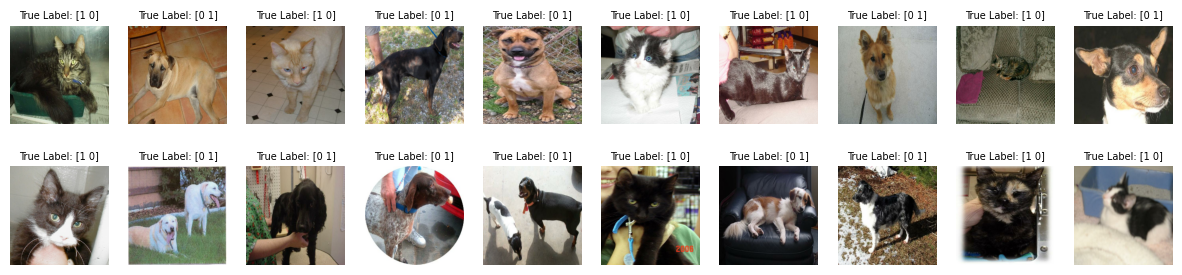

In [18]:
show_imgs(imgs_train_big[:20], labels_train_new_big[:20], [15,7], 10, font_size = 7)

<Figure size 640x480 with 0 Axes>

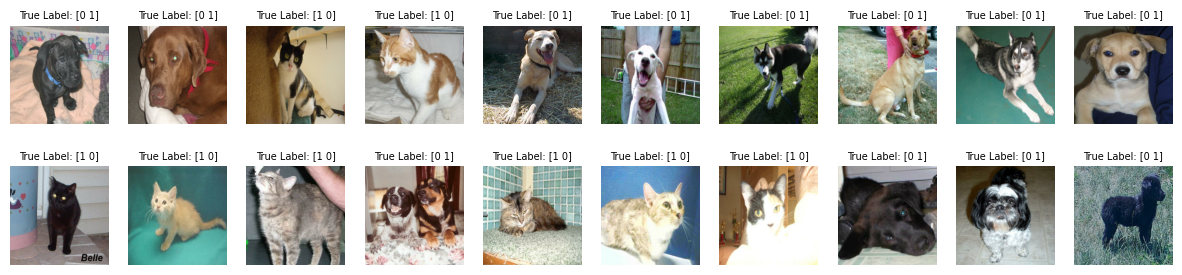

In [19]:
show_imgs(imgs_test_big[:20], labels_test_new_big[:20], [15,7], 10, font_size = 7)

In [20]:
imgs_train_big = tf.image.resize(imgs_train_big, [160,160])
imgs_test_big = tf.image.resize(imgs_test_big, [160,160])

# Loading base model

In [21]:
#seeting seed for uniform randomization
tf.random.set_seed(1234)

ResNet50V2 has been selected as the base model because it is an excellent model for transfer learning providing good accuracy in image classification tasks. If you wish you can use any transfer learning model you like.

Visit https://keras.io/api/applications/ for more details.

In [22]:
base_model = keras.applications.ResNet50V2(
    # weights = "../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape = (160,160,3),
    include_top = False,)

base_model.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [23]:
#printing few of the last layers of the base model
Total_layers = len(base_model.layers)
for i in range(Total_layers-11, Total_layers):
  print(base_model.layers[i].name)
print()
print("Total layers:", Total_layers)

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu

Total layers: 190


In [25]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 82, 82, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

# Creating transfer learning model

The transfer learning model will contain the base model with addition to:
  1. Input Layer: specifying the input of the model
  2. Rescaling layer: for normalizing the pixel values of images
  3. Global Average Pooling: to flatten the output of the last CNN block for the Dense layer
  4. Dense Layer: having 2 units with softmax activation to make prediction for dog and cat classes

The base model should be set to trainable = False, meaning it will not be trained and only the dense layer will be trained as we do not want to change the learned featured of the base model.

In [26]:
#controls for our model

#no of classes of classification
classes = 2

#activation of last dense layer
activation = "softmax"

#loss function for our model
#if binary classification loss will be BinaryCrossentropy, if multiclass classification loss will be CategoricalCrossentropy
loss_s = keras.losses.BinaryCrossentropy()

In [27]:
#start code here
inputs = keras.Input(shape = (160,160,3))
rescaling_output = Rescaling(scale = 1./255)(inputs)
last_conv_output = base_model(rescaling_output, training = False)
gap = keras.layers.GlobalAveragePooling2D()(last_conv_output) #global average pooling
outputs = keras.layers.Dense(classes, activation = activation)(gap)
model = keras.Model(inputs, outputs)

model.compile(
  loss = loss_s,
  optimizer = keras.optimizers.Adam(0.001), # learning rate = 0.001
  metrics = ["accuracy"]
)
#end code here

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________

In [29]:
display_expected_result("1Pqh0RmR0myTvs24AtrHeZTTxHFE9Rlyf", 250)

## Training the Model

You need to choose the values of hyperparameters that prove to be good for the model's accuracy.

In [30]:
history = model.fit(imgs_train_big, labels_train_new_big,
                    validation_data = (imgs_test_big, labels_test_new_big),
                    epochs = 10 , batch_size = 64)

Epoch 1/10
16/16 [==============================] - 17s 292ms/step - loss: 0.6188 - accuracy: 0.7220 - val_loss: 0.2241 - val_accuracy: 0.9200
Epoch 2/10
16/16 [==============================] - 2s 145ms/step - loss: 0.1646 - accuracy: 0.9460 - val_loss: 0.1314 - val_accuracy: 0.9450
Epoch 3/10
16/16 [==============================] - 2s 140ms/step - loss: 0.1128 - accuracy: 0.9600 - val_loss: 0.1144 - val_accuracy: 0.9450
Epoch 4/10
16/16 [==============================] - 2s 118ms/step - loss: 0.0905 - accuracy: 0.9700 - val_loss: 0.1119 - val_accuracy: 0.9500
Epoch 5/10
16/16 [==============================] - 2s 119ms/step - loss: 0.0753 - accuracy: 0.9790 - val_loss: 0.1013 - val_accuracy: 0.9600
Epoch 6/10
16/16 [==============================] - 2s 139ms/step - loss: 0.0618 - accuracy: 0.9850 - val_loss: 0.0994 - val_accuracy: 0.9550
Epoch 7/10
16/16 [==============================] - 2s 119ms/step - loss: 0.0530 - accuracy: 0.9890 - val_loss: 0.0962 - val_accuracy: 0.9650
Epoch

You may save the learned weights and load them, instead of training the model again and again.

In [31]:
#saving the weights of the model
#start code here
weights_path = "/content/weights"
model.save_weights(weights_path)
# model.load_weights(weights_path)
#end code here

# Creating Grad_Model

By using the Transfer model, make a Grad_Cam model that outputs the last convolution output and also the softmax predictions.

In [32]:
#using the architecture of the previous model to make our gradcam model
grad_model = Model(inputs = inputs, outputs = [last_conv_output, outputs])

In [33]:
grad_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_______________

# Steps for creating Grad_CAM

STEPS for creating grad_cam:
  1. Derivative of the raw score of the interested class with respect to the last convolutional output
  2. Global average pooling of the result to get the "importance weights": a 1-D vector
  3. Linear combination of the result of importance weights and the last conv output
  4. Applying ReLU or Normalizing the output between 0 and 1
  5. Superimposing the heatmap and the original image

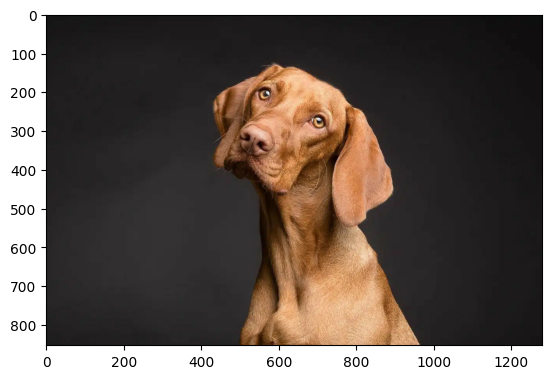

In [38]:
# #loading an image for grad_cam generation
# #start code here
# img_path = "/content/dog.jpeg"
# #resizing it according to the size of input layer of the model

# img_size = tf.image.resize(img_path, [160,160])
# #end code here
# print(img.shape)


image_path = "/content/dog.jpeg"
img = tf.io.read_file(image_path)
img.get_shape().as_list()  # []
img = tf.image.decode_jpeg(img)
img.get_shape().as_list()  # [300, 400, 3]
plt.imshow(img)

In [39]:
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (160, 160))
img = tf.expand_dims(img, 0)
print(img.shape)

(1, 160, 160, 3)


In [40]:
img

<tf.Tensor: shape=(1, 160, 160, 3), dtype=float32, numpy=
array([[[[21.       , 21.       , 21.       ],
         [21.       , 21.       , 21.       ],
         [21.       , 21.       , 21.       ],
         ...,
         [16.       , 14.       , 15.       ],
         [16.       , 14.       , 15.       ],
         [18.       , 14.       , 15.       ]],

        [[21.       , 21.       , 21.       ],
         [21.       , 21.       , 21.       ],
         [21.       , 21.       , 21.       ],
         ...,
         [16.       , 14.       , 15.       ],
         [16.993752 , 14.       , 15.       ],
         [14.006249 , 15.496876 , 15.       ]],

        [[21.       , 21.       , 21.       ],
         [21.       , 21.       , 21.       ],
         [21.       , 21.       , 21.       ],
         ...,
         [15.0859375, 14.9140625, 15.       ],
         [16.       , 14.       , 15.       ],
         [12.171875 , 16.       , 15.       ]],

        ...,

        [[30.       , 30.       , 

## Step_1: Derivative

The derivative of the raw scores of a selected class (either cat or dog) is taken with respect to the last convolutional output(a 3D matrix) that gives us a matrix having the shape same as the shape of the conv output(i.e the derivative will also be a 3D matrix).

In [41]:
#making grad_cams with respect to dog class
class_index = 1

To get the raw score, the activations of the last layer must be set to none

In [42]:
#remove the activation of last layer to get the raw scores rather than predictions
#start code here
grad_model.layers[-1].activation = None
#end code here

In [43]:
# predict the image to get the the last conv output and predictions and get the raw score of the interested class

#variables that are used in the differentiation must be inside the tape block
with tf.GradientTape() as tape:
  #start code here
  tape.watch(img)

  last_conv, raw_output = grad_model(img)

  dog_raw_score = raw_output[0][1]
  #end code here
raw_output[0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=3.576307>

In [44]:
#start code here
print("shape of last conv output:", last_conv.shape)
print()
print("raw scores:", raw_output)
print("raw scores of interested class:", dog_raw_score)
#end code here

shape of last conv output: (1, 5, 5, 2048)

raw scores: tf.Tensor([[-7.271284  3.576307]], shape=(1, 2), dtype=float32)
raw scores of interested class: tf.Tensor(3.576307, shape=(), dtype=float32)


In [45]:
# TAKING THE DERIVATIVE
# the shape of the derivative will be the same as the shape of last conv output
#start code here
grads = tape.gradient(dog_raw_score,last_conv)
print(grads.shape)
#end code here

(1, 5, 5, 2048)


## Step_2: Global Average Pooling

Taking global average pooling of the derivative gives us a 1D vector(having the same depth as the depth of the derivative) called "importance weights". The reason the vector is so called because it tells us which channels of the last conv output are important in predicting the selected class.

Global average pooling can be achieved by tf.reduce_mean

In [46]:
# global average pooling of each feature map
#start code here
gap_grads = keras.layers.GlobalAveragePooling2D()(grads)
#notice that the lenght of the of the result is equal to the depth of the derivative
print(gap_grads.shape)
#end code here

(1, 2048)


## Step_3: Linear Combination

Linear combination of the 1D vector (importance weights) and the last conv output is carried out in which each importance weight is multiplied with its corresponding channel in the conv output and then all the channels are added into each other to get a single 2D matrix.

The height and width of the resultant matrix must be equal to the height and width of the last conv output.

In [47]:
#multiplying each pooled value with its correponding feature map
#start code here
heatmap = tf.reduce_sum(tf.multiply(gap_grads[:, tf.newaxis, tf.newaxis, :], last_conv), axis=-1)
print(heatmap.shape)
#end code here

(1, 5, 5)


To remove the extra dimensions of value 1, you can use tf.squeeze

In [49]:
#removing the extra dimensions of value 1
#start code here
heatmap = tf.squeeze(heatmap)
#notice the shape of the output
print(heatmap.shape)
#end code here

(5, 5)


## Step_4: Normalizing output

Normalize the pixel values between 0 and 1

In [50]:
# For visualization purpose, we will normalize the heatmap between 0 & 1
#start code here
heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
print(heatmap.shape)
print(heatmap)
#end code here

(5, 5)
tf.Tensor(
[[0.08302176 0.07138177 0.04321546 0.03956489 0.05438511]
 [0.07251653 0.         0.14778477 0.252625   0.05706218]
 [0.06989077 0.18871842 0.5114139  0.46474928 0.3074856 ]
 [0.09086599 0.24724802 0.89296186 1.         0.60395277]
 [0.07429571 0.19244753 0.24049203 0.36134186 0.143266  ]], shape=(5, 5), dtype=float32)


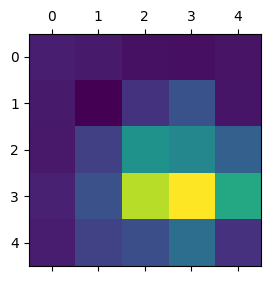

In [51]:
#visualizing the heatmap
plt.figure(figsize=(3,3))
plt.matshow(heatmap, fignum=1)

In [52]:
display_expected_result("1fXOJeFPvVxFY5fPDl5ad9UPEdSOzYNJZ", 200)

## Step_5: Superimpose

In order to superimpose the heatmap and the image, we need to:
  1. Rescale the values to the range: 0 - 255
  2. Make the heatmap to have 3 channels: R,G,B and mapping the values to colors according to their intensities
  3. Resizing the heatmap to the size of the image
  4. finally superimpose

### a. Rescaling to 0 - 255

In [53]:
# Rescale heatmap to a range 0-255 because RGB values range from 0 - 255
#start code here
heatmap = heatmap * 255

# Convert to integer type for RGB values
heatmap = tf.cast(heatmap, tf.uint8)
print(heatmap.shape)
print(heatmap)
#end code here

(5, 5)
tf.Tensor(
[[ 21  18  11  10  13]
 [ 18   0  37  64  14]
 [ 17  48 130 118  78]
 [ 23  63 227 255 154]
 [ 18  49  61  92  36]], shape=(5, 5), dtype=uint8)


In [54]:
display_expected_result("1xV4VYhDnKAI9HjBSQXfpyrqJFbfIAtiM", 120)

### b. Creating RGB channels

The matrix is converted into the heatmap by giving it RGB channels such that the values correspond to the color intensities. The highest values in the matrix correspond to shades of red and the lowest values correspond to the blue.

<ipython-input-55-e38f782b9a91>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


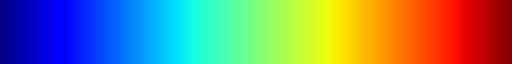

In [55]:
# Use jet colormap to colorize the heatmap corresponding the the intensities
jet = cm.get_cmap("jet")
jet

In [56]:
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
print(jet_colors.shape)

(256, 3)


shape of jet_heatmap: (5, 5, 3)


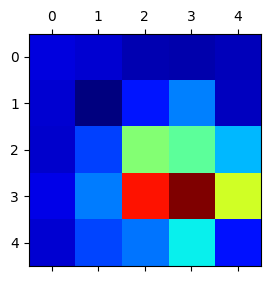

In [57]:
jet_heatmap = jet_colors[heatmap]
print("shape of jet_heatmap:", jet_heatmap.shape)

#visualizing the heatmap
plt.figure(figsize=(3,3))
plt.matshow(jet_heatmap, fignum=1)

In [58]:
display_expected_result("1D1OFC-w8P4sVjXRbshCgYE3HL_VLZf26", 200)

### c. Resizing the heatmap

Now resized the colorized heatmap to the original dimensions of the image. TensorFlow can be used to easily resize "images", not matrices, with a single function: img.resize()

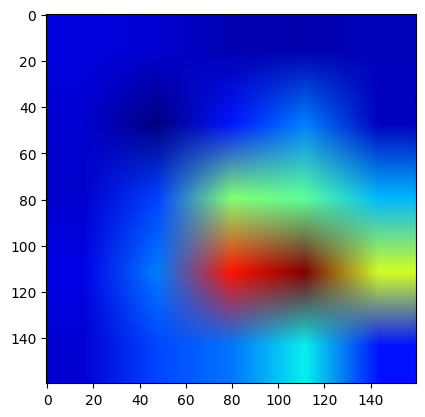

In [59]:
# Converting the heatmap from array to image to resize it to the size of the original image
#start code here
jet_heatmap = tf.image.resize(jet_heatmap, (img.shape[1], img.shape[2]))

#visualizing the heatmap
plt.imshow(jet_heatmap)
#end code here

In [60]:
display_expected_result("1p6f55pM6g-2OBX5kCDUpXA5OtmgZuifB", 300)

### d. Finally superimposing

(853, 1280, 3)


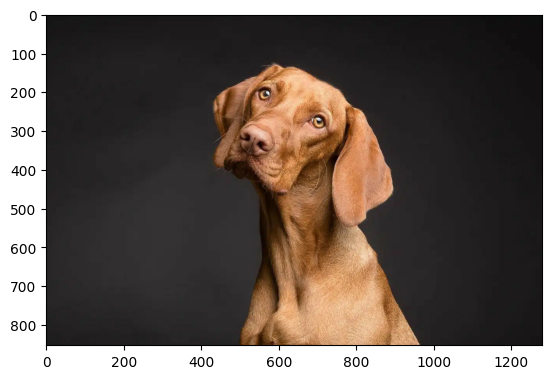

In [61]:
#reloading the original image in its true dimensions
#start code here
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img)
img = tf.cast(img, tf.float32) / 255.0
#visualizing the image
plt.imshow(img)
print(img.shape)
#end code here

In [62]:
jet_heatmap

<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.87433153],
        [0.        , 0.        , 0.87433153],
        [0.        , 0.        , 0.87433153],
        ...,
        [0.        , 0.        , 0.73172903],
        [0.        , 0.        , 0.73172903],
        [0.        , 0.        , 0.73172903]],

       [[0.        , 0.        , 0.87433153],
        [0.        , 0.        , 0.87433153],
        [0.        , 0.        , 0.87433153],
        ...,
        [0.        , 0.        , 0.73172903],
        [0.        , 0.        , 0.73172903],
        [0.        , 0.        , 0.73172903]],

       [[0.        , 0.        , 0.87433153],
        [0.        , 0.        , 0.87433153],
        [0.        , 0.        , 0.87433153],
        ...,
        [0.        , 0.        , 0.73172903],
        [0.        , 0.        , 0.73172903],
        [0.        , 0.        , 0.73172903]],

       ...,

       [[0.        , 0.        , 0.8208556 ],
        [0.  

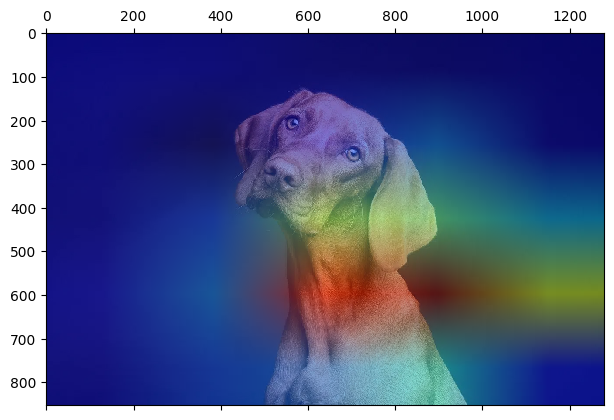

In [63]:
# Intensity control
alpha = 0.5

# Resize the heatmap to match the shape of the original image
jet_heatmap_resized = tf.image.resize(jet_heatmap, [img.shape[0], img.shape[1]])

# Superimposing the resized heatmap on the original image
# First, ensure that both the heatmap and the original image are normalized to the range [0, 1]
jet_heatmap_resized = jet_heatmap_resized
superimposed_img = (img * (1 - alpha)) + (jet_heatmap_resized * alpha)
superimposed_img = tf.clip_by_value(superimposed_img, 0, 1)  # Ensure values are within [0,1]

# Visualizing the Grad-CAM
plt.matshow(superimposed_img)

In [64]:
display_expected_result("1PQSekm2ZeGLQN71-5kKduSr4Z0biA7fb", 300)

## **End Task 1:**

Now use any 3 images of your own choice and create their grad_cams.

Briefly explain what you understand from the grad_cams of the images.

You may share anything relevant you have observed in the results that has not been discussed in the lab.

# Grad_Cams from different conv layers

In order to further understand the behaviour of our CNN model, we will generate grad_cams by using convolution outputs of intermediate layers. This will allow us to analyse the learning the model at different stages.

In this task, you will not construct a transfer learning model, instead you will use only the base model to make the grad_cam models because TensorFlow does not provide the functionality to access the internal layers' outputs of a base model.

---

In order to use the base model's outputs you have to use the decode_predictions method of your base_model to decode the predictions.
Same is the case with the inputs.

Refer https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/decode_predictions

and

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input

for further details.

Following image should give you an idea of what to expect when using preprocess_input and decode_predictions via code.

In [65]:
display_expected_result("1LjaQdXfUyOO2q8xjiEzih0rka1IlLjCT", 150)

# **Using MobilenetV2**

In [103]:
model = tf.keras.applications.MobileNetV2(weights='imagenet')

In [104]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import cv2

In [105]:
#loading the model
#start code here
base_model = keras.applications.ResNet50V2(
    # weights = "../input/ResNet50V2/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape = (224,224,3),
    include_top = True)

base_model.trainable = False
preprocess_input = preprocess_input
decode_predictions = decode_predictions
#ebd code here

In [106]:
img_path = 'dog.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [107]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [108]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    return heatmap

In [109]:
last_conv_layer_name = 'Conv_1'
classifier_layer_names = ['Predictions']

img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

In [110]:
# Superimpose the heatmap on the original image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('gradcam.jpg', superimposed_img)


True

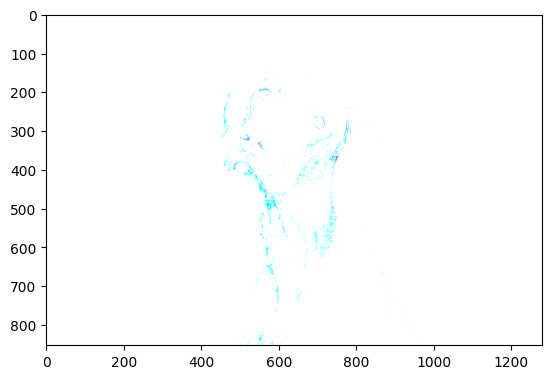

In [111]:
plt.imshow(superimposed_img)
plt.show()

# **Using VGG16**

In [128]:
# Load the pre-trained model
model = tf.keras.applications.VGG16(weights='imagenet')

In [114]:
# Load and preprocess the image
img_path = 'dog.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

In [115]:
# Get the class index
preds = model.predict(x)
class_index = np.argmax(preds[0])

1/1 [==============================] - 0s 269ms/step


In [116]:
# Vanilla Backpropagation
with tf.GradientTape() as tape:
    inputs = tf.cast(x, tf.float32)
    tape.watch(inputs)
    preds = model(inputs)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [117]:
# Generate the heatmap for Vanilla Backpropagation
grads = tape.gradient(top_class_channel, inputs)
heatmap_vanilla = tf.reduce_mean(grads, axis=-1)

In [118]:
# Guided Backpropagation
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad

In [119]:
guided_model = tf.keras.models.clone_model(model)
layer_dict = dict([(layer.name, layer) for layer in guided_model.layers])
for layer in guided_model.layers:
    if hasattr(layer, 'activation'):
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu

In [120]:
with tf.GradientTape() as tape:
    inputs = tf.cast(x, tf.float32)
    tape.watch(inputs)
    preds = guided_model(inputs)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [121]:
# Generate the heatmap for Guided Backpropagation
grads = tape.gradient(top_class_channel, inputs)
heatmap_guided = tf.reduce_mean(grads, axis=-1)

In [122]:
# Post-process the heatmaps and save them
heatmap_vanilla = np.maximum(heatmap_vanilla, 0)
heatmap_vanilla /= tf.reduce_max(heatmap_vanilla)
heatmap_vanilla = heatmap_vanilla.numpy()[0]

In [123]:
heatmap_guided = np.maximum(heatmap_guided, 0)
heatmap_guided /= tf.reduce_max(heatmap_guided)
heatmap_guided = heatmap_guided.numpy()[0]

In [124]:
# Superimpose the heatmaps on the original image
img = cv2.imread(img_path)
heatmap_vanilla = cv2.resize(heatmap_vanilla, (img.shape[1], img.shape[0]))
heatmap_vanilla = np.uint8(255 * heatmap_vanilla)
heatmap_vanilla = cv2.applyColorMap(heatmap_vanilla, cv2.COLORMAP_JET)
superimposed_img_vanilla = heatmap_vanilla * 0.4 + img

In [125]:
heatmap_guided = cv2.resize(heatmap_guided, (img.shape[1], img.shape[0]))
heatmap_guided = np.uint8(255 * heatmap_guided)
heatmap_guided = cv2.applyColorMap(heatmap_guided, cv2.COLORMAP_JET)
superimposed_img_guided = heatmap_guided * 0.4 + img

In [126]:
cv2.imwrite('vanilla_backpropagation.jpg', superimposed_img_vanilla)

True

In [127]:
cv2.imwrite('guided_backpropagation.jpg', superimposed_img_guided)

True

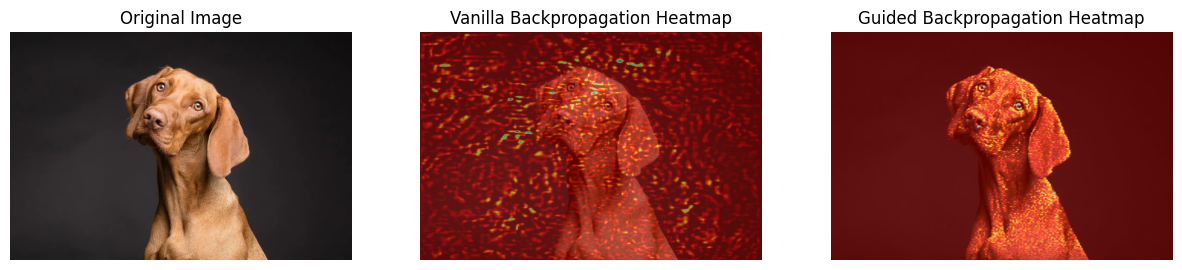

In [96]:
# Display the heatmaps and original images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
axs[0].imshow(img)
axs[0].set_title('Original Image')

# Display the heatmap for Vanilla Backpropagation
axs[1].imshow(img)
axs[1].imshow(heatmap_vanilla, alpha=0.6, cmap='jet')
axs[1].set_title('Vanilla Backpropagation Heatmap')

# Display the heatmap for Guided Backpropagation
axs[2].imshow(img)
axs[2].imshow(heatmap_guided, alpha=0.6, cmap='jet')
axs[2].set_title('Guided Backpropagation Heatmap')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Show the plots
plt.show()

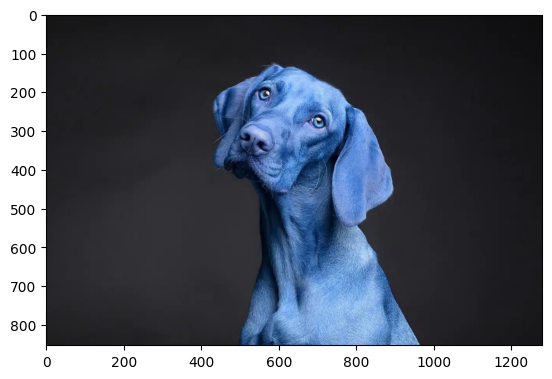

In [133]:
plt.imshow(img)

In [71]:
# keras.utils.plot_model(base_model)

In [129]:
# for i in range(len(base_model.layers)):
#   print("[" + str(i) + "]:", end = " ")
#   print(base_model.layers[i].name)

You may select any two conv outputs, one must be from the first quarter and the second from the 2nd or 3rd quarter.

Make two grad_models that will provide the above mentioned outputs.

Then use those models to generate grad_cams of a single image at different levels.

In [130]:
# generate the grad_models
#start code here
# grad_model_start = ;

# grad_model_mid = ;
#endd code here

In [135]:
#start code here
# img = ;
#visualizing the image
# plt.imshow(img)
#end code here

In [136]:
#generate gradcams using the two grad_cam models
#start code here

#end code here

In [137]:
#expected result from the starting layer
# display_expected_result("15vcOIPUwmmhOgClVngcK5sFbkQjhUGeZ", 250)

In [138]:
#expected result from the mid layer
# display_expected_result("1Gy-GniW196LGeWoRufxwmpd1bYdP8yu8", 250)

## **End Task 2:**

Now use any 3 images of your own choice and create their grad_cams from both of your models.

Briefly explain what you understand from the grad_cams of the images.

You may share anything relevant you have observed in the results that has not been discussed in the lab.